# Install Libraries

In [ ]:
%pip install monai
%pip install datasets
%pip install -q git+https://github.com/huggingface/transformers.git
%pip install patchify

# Import Dependencies

In [2]:
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from scipy import ndimage
import tifffile
from torch.utils.data import DataLoader
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from PIL import Image
import io
from patchify import patchify

# Notebook for Testing Model Results

We trained two separate models, one on a smaller dataset (test_model) for 4 epochs, which took about 2 hours, and one for 2 epochs on the full dataset (train_model), which took over 7 hours. Due to constraints on our compute resources, we were unable to train for further epochs, but using the Nvidia A100 on colab at least allowed us to train without swamping our GPU RAM. The test_model achieved a loss rate of ~51%, and the train_model ~50%. In this notebook, we test the results on the val split to decide which model yields better results. The first 9 cells are largely dedicated to preparing the data and downloading the models, and the actual test results are contained in the final two cells.

In [ ]:
sidewalk_test = load_dataset("back2classroom/sidewalks", split='val', streaming=True)

In [4]:
test_images = []
test_labels = []

# Loop through the streamed dataset and collect images and masks
for sample in sidewalk_test:
    test_images.append(sample['tif'])
    test_labels.append(sample['label_tif'])

# Decode a JPEG byte string to a NumPy array
def decode_jpeg_to_array(jpeg_bytes):
    with io.BytesIO(jpeg_bytes) as byte_stream:
        image = Image.open(byte_stream)
        return np.array(image)

valid_indices = []
false_counter = 0

for i, mask_bytes in enumerate(test_labels):
    mask_np = decode_jpeg_to_array(mask_bytes)
    # Check if any pixel in the mask is not zero
    if np.any(mask_np != 0):
        valid_indices.append(i)
    else:
        false_counter += 1

print("Empty masks: ", false_counter)


filtered_images = [test_images[i] for i in valid_indices]
filtered_masks = [test_labels[i] for i in valid_indices]

Empty masks:  9917


In [5]:
# Convert byte arrays to numpy arrays
def convert_to_numpy(byte_data):
    with io.BytesIO(byte_data) as byte_stream:
        image = Image.open(byte_stream)
        image_np = np.array(image)
        return image_np

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [6]:
dataset_dict = {
    "image": filtered_images,  # Directly use the byte data
    "label": filtered_masks,   # Directly use the byte data
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

# Test Dataset Load

Sanity check to ensure data was loaded and indexed properly

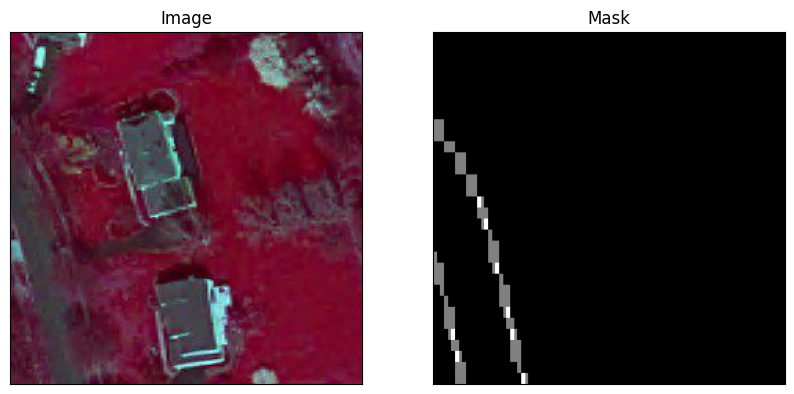

In [7]:
img_num = random.randint(0, convert_to_numpy(filtered_images[0]).shape[0]-1)

image_np = dataset[img_num]["image"]
mask_np = dataset[img_num]["label"]

image_np = convert_to_numpy(image_np)
mask_np = convert_to_numpy(mask_np)

example_image = Image.fromarray(image_np)
example_mask = Image.fromarray(mask_np)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Inference Testing

In [8]:
from transformers import SamModel, SamConfig, SamProcessor

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [9]:
test_model_path = "/content/drive/MyDrive/Colab Notebooks/model_checkpoint_trained_on_test.pth"
train_model_path = "/content/drive/MyDrive/Colab Notebooks/model_checkpoint_trained_on_train.pth"

# Create an instance of the model architecture with the loaded configuration
test_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
test_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/model_checkpoint_trained_on_test.pth"))

# Create an instance of the model architecture with the loaded configuration
train_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
train_model.load_state_dict(torch.load(train_model_path))

<All keys matched successfully>

In [10]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
test_model.to(device)
train_model.to(device)
print(device)

cuda


# Convenience Function to Visualize Results

In [11]:
def visualize_segmentation_example(dataset, test_model, processor, device):
    """
    Visualizes a segmentation example from the dataset using the provided model and processing functions.

    Args:
        dataset (Dataset): A HF list of data samples containing images and labels.
        test_model (torch.nn.Module): The segmentation model to be used for inference.
        processor: The pre-processing function for the model input.
        device: The device (CPU or GPU) to perform inference on.
    """
    # Let's take a random training example
    idx = random.randint(0, convert_to_numpy(filtered_images[0]).shape[0] - 1)

    # Load image
    test_image = Image.fromarray(convert_to_numpy(dataset[idx]["image"]))

    # Get box prompt based on ground truth segmentation map
    ground_truth_mask = convert_to_numpy(dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # Prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    test_model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = test_model(**inputs, multimask_output=False)

    # Apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # Convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title("Image")

    # Plot the second image on the right
    axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
    axes[1].set_title("Mask")

    # Plot the third image on the right
    axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
    axes[2].set_title("Probability Map")

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()


# Test Model Trained on Smaller Dataset

A simple visual test to see performance of test_model (trained on smaller dataset). The original image, the given mask label, and the predicted probability map output by the model are displayed side by side. As we can see, the model achieved very good results despite being finetuned on a smaller dataset

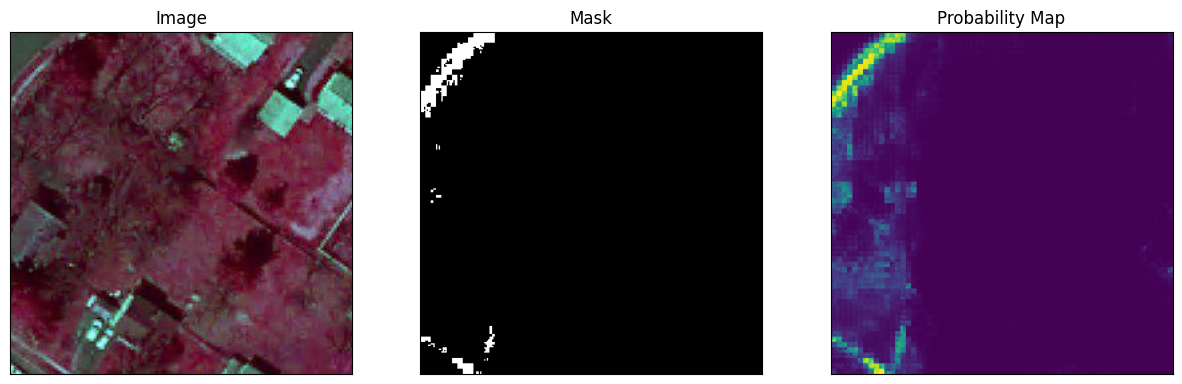

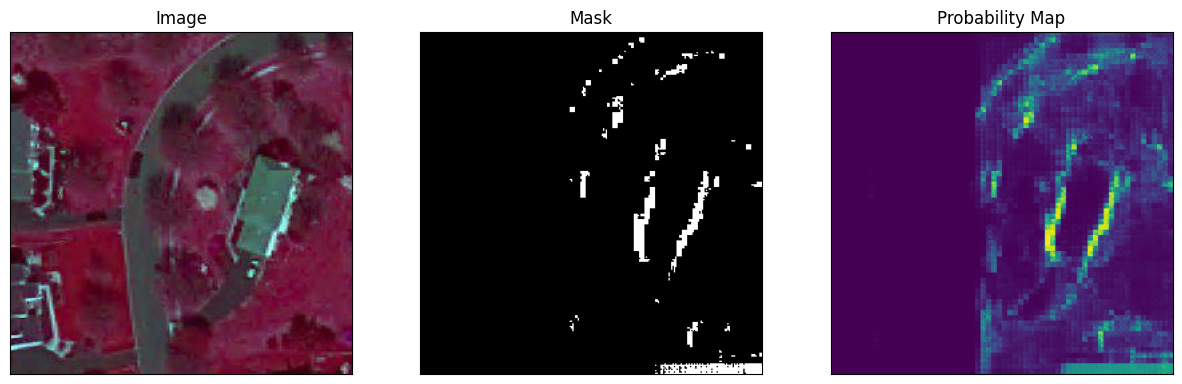

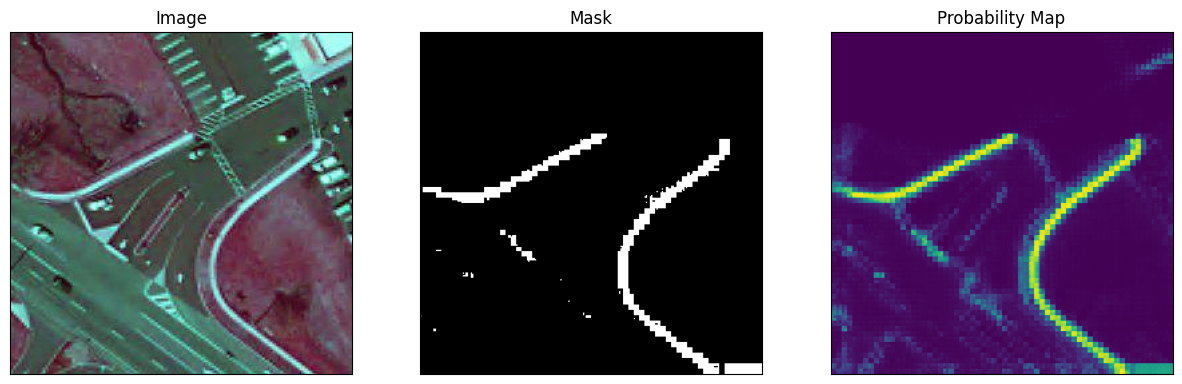

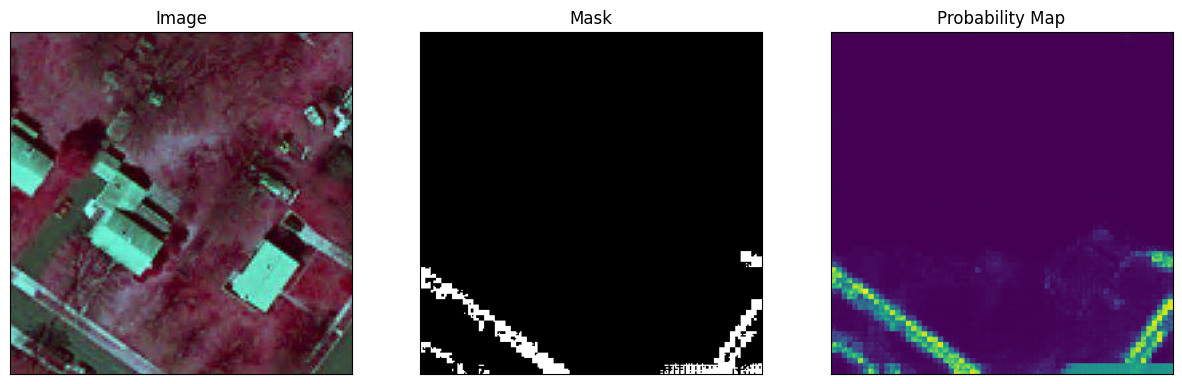

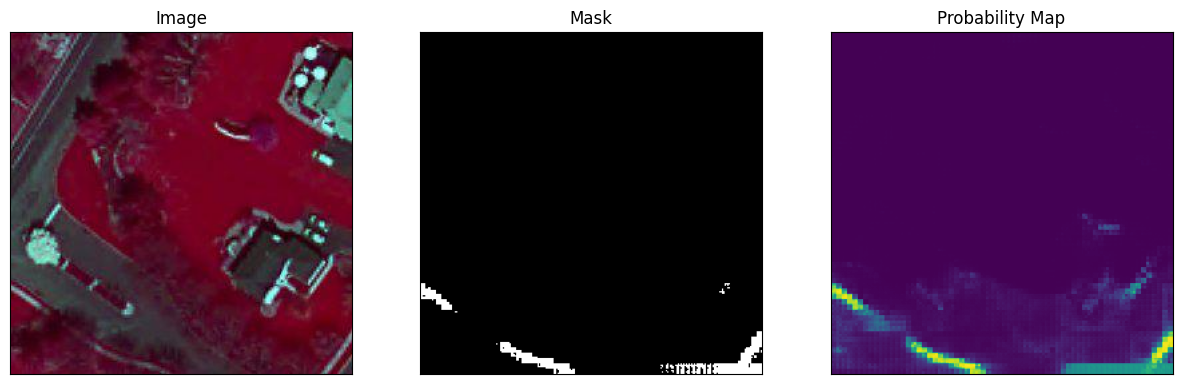

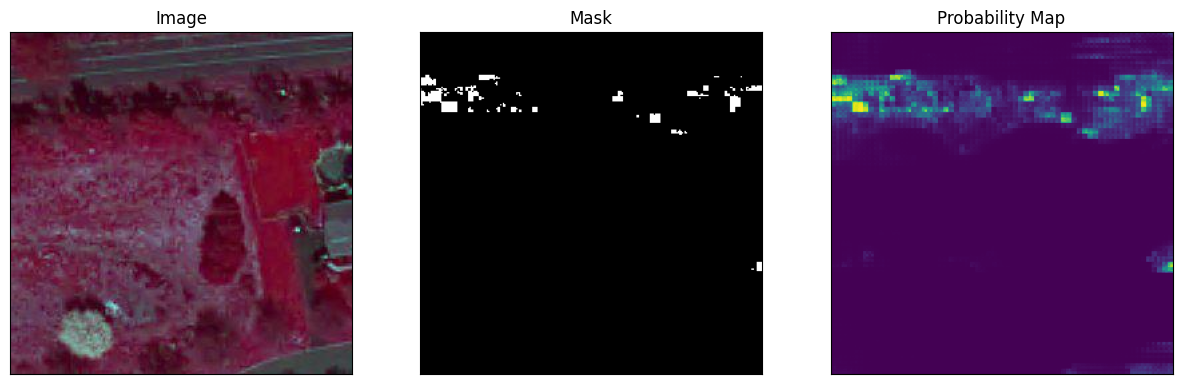

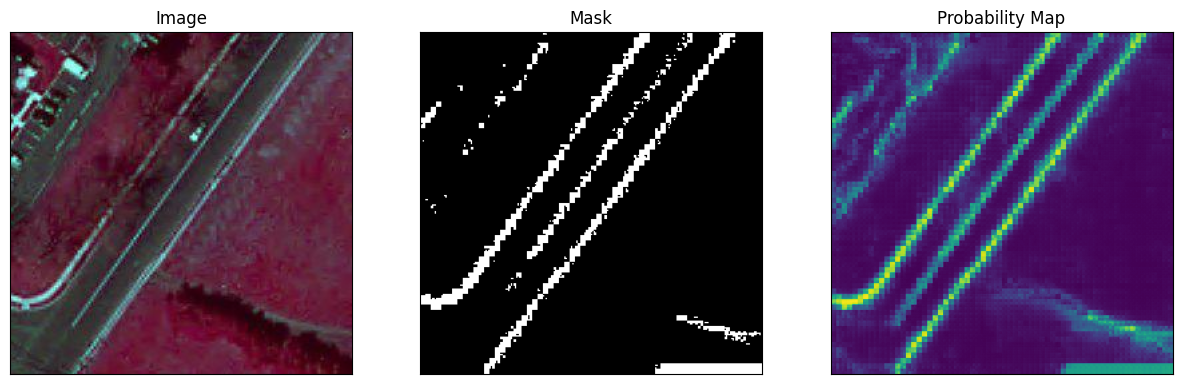

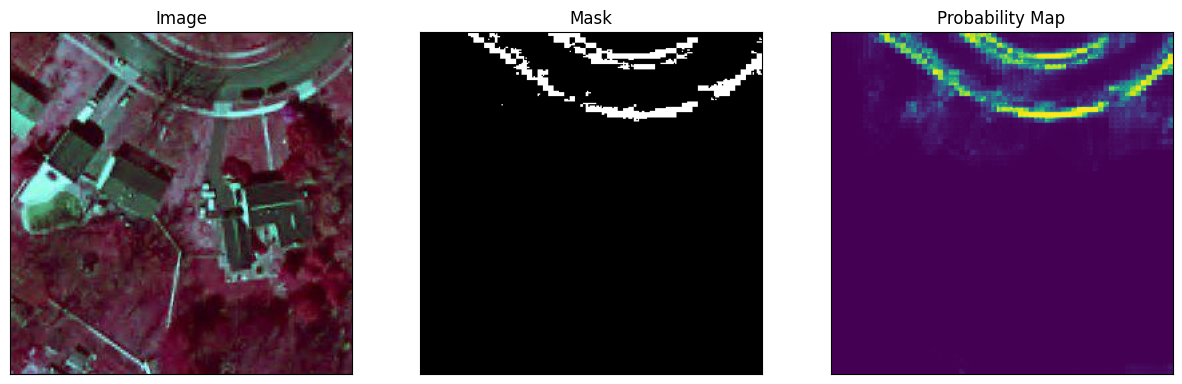

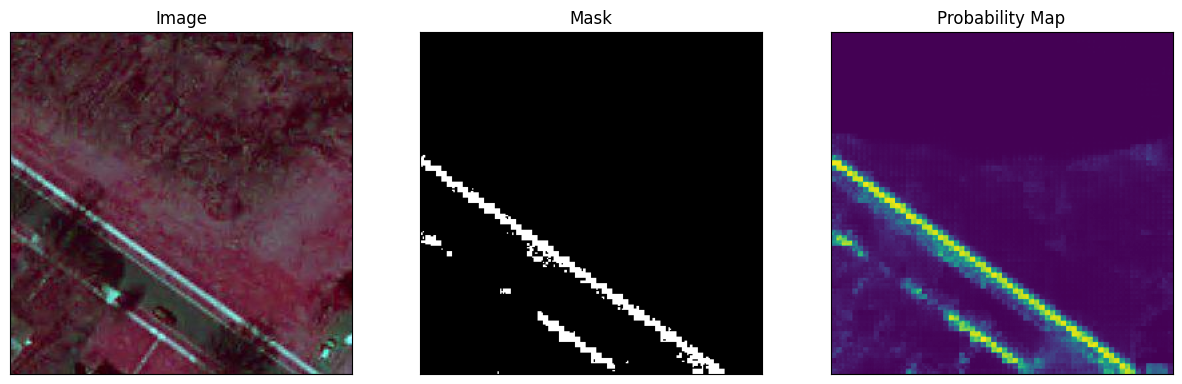

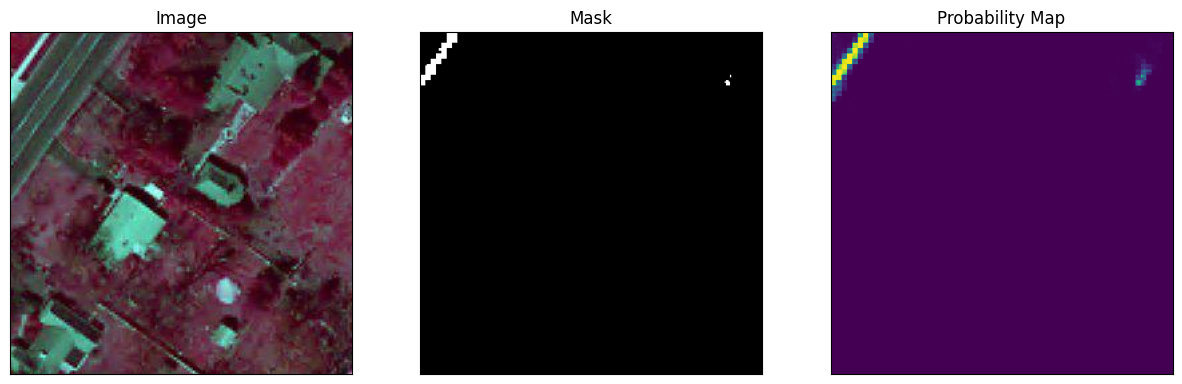

In [12]:
for i in range(10):
  visualize_segmentation_example(dataset, test_model, processor, device)


# Test Model Trained on Full Datset

A simple visual test to see performance of train_model (trained on full dataset). Method is the same as above, with the original image, the given mask label, and the predicted probability map displayed. The results are similar to the test_model, although notice that it sometimes outperforms the mask label (notice in the first image that our model predicts that middle sidewalk better than shown in the mask). More importantly, due to the larger dataset, we believe that this model will be more generalizable than the test_model, so we chose to use this model for our web app.

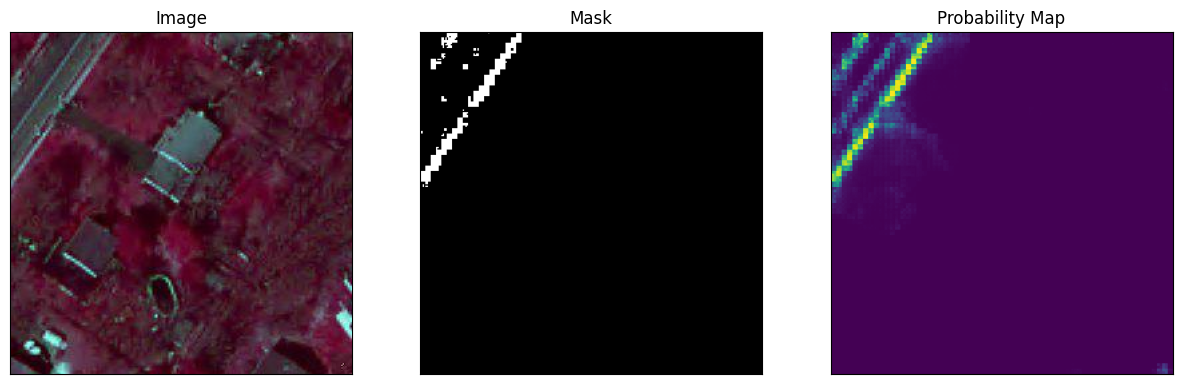

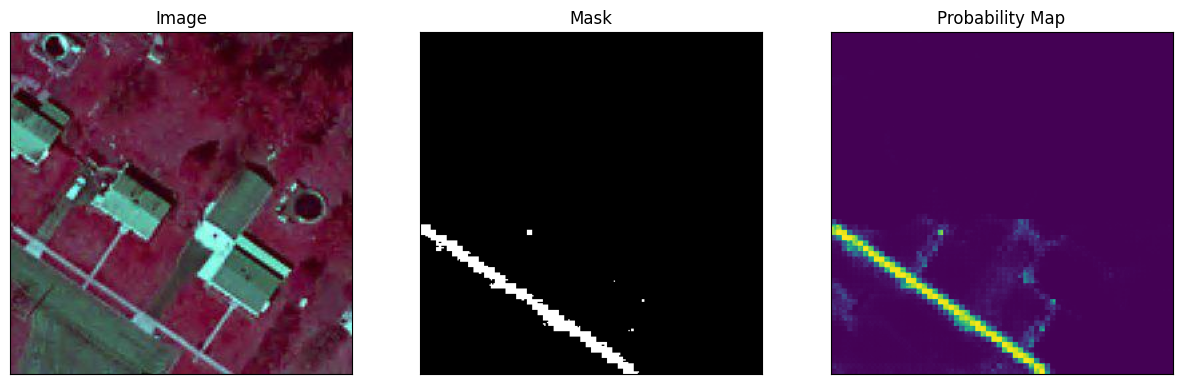

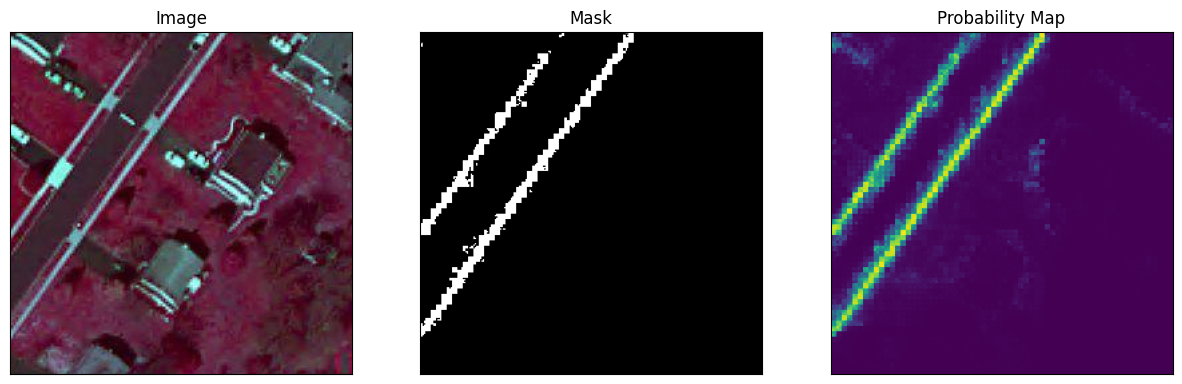

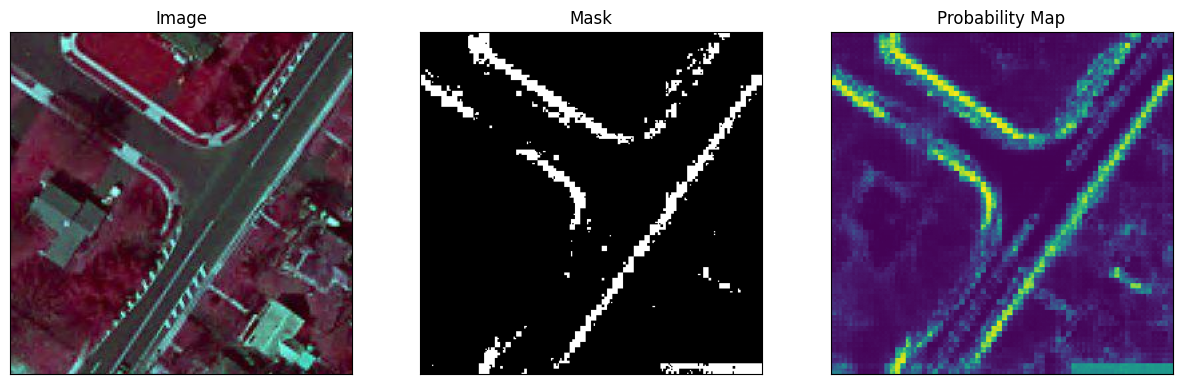

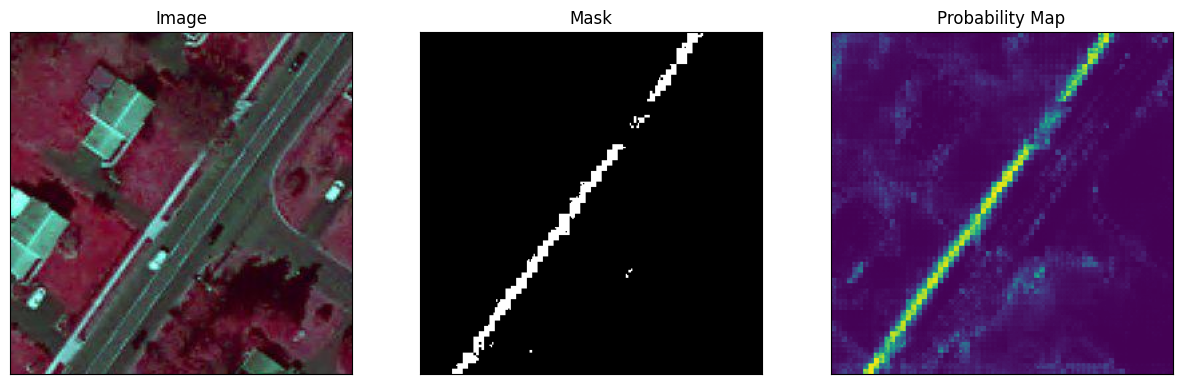

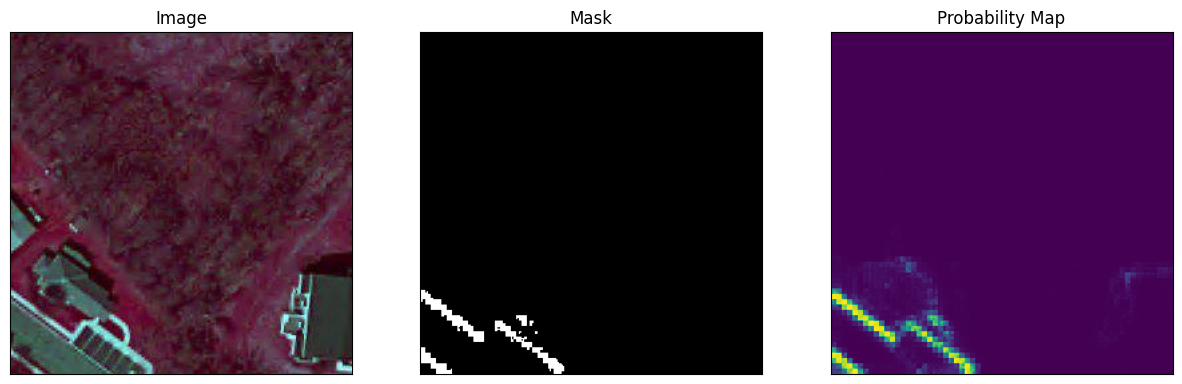

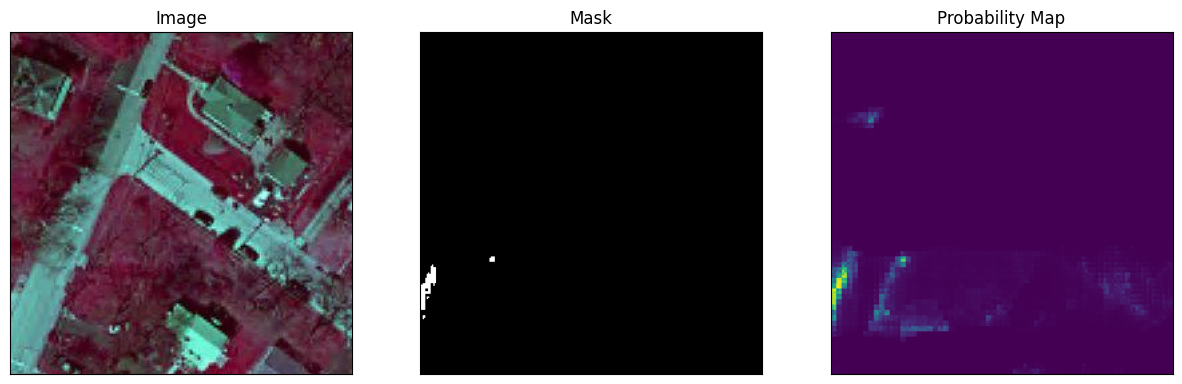

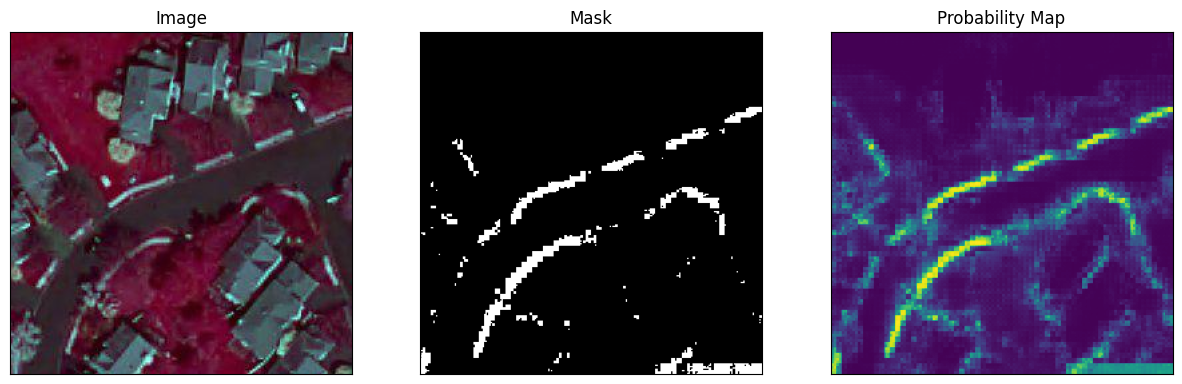

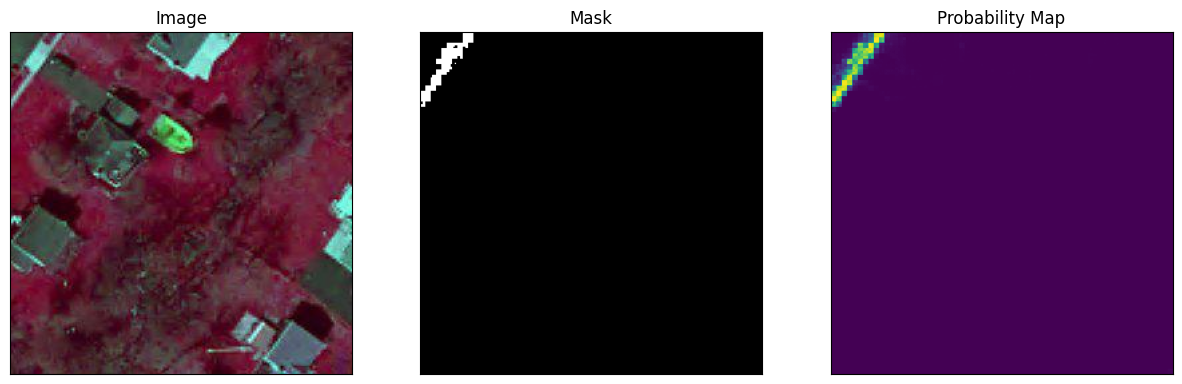

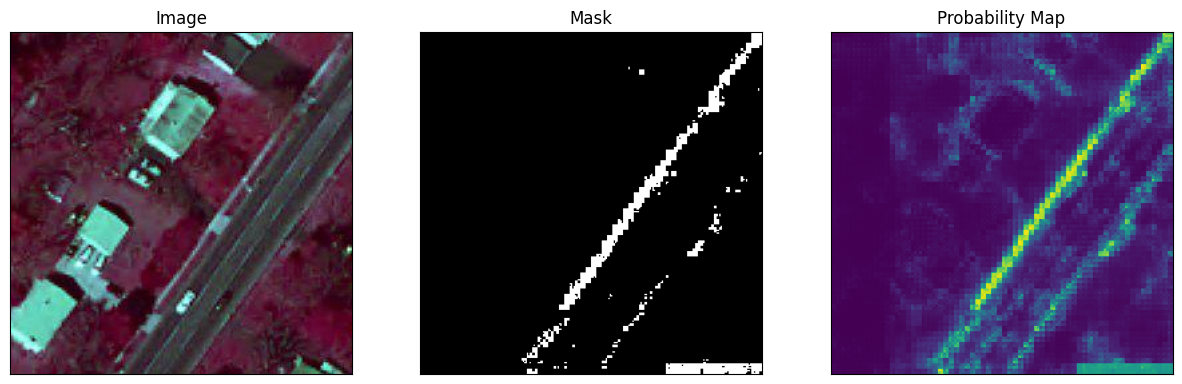

In [13]:
for i in range(10):
  visualize_segmentation_example(dataset, train_model, processor, device)